We will import and clean a variety of data sources provided by New York City Public Schools. We will them explore correlations and visualizations to see if there are any notable relationships in the data.

In [2]:
import pandas as pd
import numpy as np

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]
data = {}

# Read data from csv files into a dictionary for future reference
for filename in data_files:
    df = pd.read_csv("schools/"+filename)
    data[filename.split(".")[0]] = df

We have read each file into a pandas dataframe, and then stored all of the dataframes in a dictionary. This will give us a convenient way to store them, and a quick way to reference them in the future.

In [3]:
data.keys()

dict_keys(['ap_2010', 'class_size', 'demographics', 'graduation', 'hs_directory', 'sat_results'])

Let's explore sat_results to see what we can discover. Exploring the dataframe will help us understand the structure of the data, and make it easier for us to analyze it.

In [4]:
data["sat_results"].head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384


The DBN appears to be a unique ID for each school. Let's explore all the dataframes.

In [5]:
for key in data.keys():
    print(data[key].head())

      DBN                             SchoolName AP Test Takers   \
0  01M448           UNIVERSITY NEIGHBORHOOD H.S.              39   
1  01M450                 EAST SIDE COMMUNITY HS              19   
2  01M515                    LOWER EASTSIDE PREP              24   
3  01M539         NEW EXPLORATIONS SCI,TECH,MATH             255   
4  02M296  High School of Hospitality Management               s   

  Total Exams Taken Number of Exams with scores 3 4 or 5  
0                49                                   10  
1                21                                    s  
2                26                                   24  
3               377                                  191  
4                 s                                    s  
   CSD BOROUGH SCHOOL CODE                SCHOOL NAME GRADE  PROGRAM TYPE  \
0    1       M        M015  P.S. 015 Roberto Clemente     0K       GEN ED   
1    1       M        M015  P.S. 015 Roberto Clemente     0K          CTT   
2    1

Each data set appears to either have a DBN column, or the information we need to create one. Some fields look interesting for mapping -- particularly Location 1, which contains coordinates inside a larger string. Some of the data sets appear to contain multiple rows for each school (because the rows have duplicate DBN values). That means we’ll have to do some preprocessing to ensure that each DBN is unique within each data set.

Now let's read in survey_all.txt and survey_d75.txt, using the keyword argument encoding="windows-1252", as we know these files are encoded in that format. Then we can combine the data into a single dataframe by using the pandas concat() function along axis 0.

In [6]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding = "windows-1252")
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding = "windows-1252")
survey = pd.concat([all_survey, d75_survey], axis=0, sort=False)

survey.head()

,dbn,bn,schoolname,d75,studentssurveyed,highschool,schooltype,rr_s,rr_t,rr_p,...,s_q14_2,s_q14_3,s_q14_4,s_q14_5,s_q14_6,s_q14_7,s_q14_8,s_q14_9,s_q14_10,s_q14_11
0,01M015,M015,P.S. 015 Roberto Clemente,0,No,0.0,Elementary School,NaN,88,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01M019,M019,P.S. 019 Asher Levy,0,No,0.0,Elementary School,NaN,100,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01M020,M020,P.S. 020 Anna Silver,0,No,0.0,Elementary School,NaN,88,73,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01M034,M034,P.S. 034 Franklin D. Roosevelt,0,Yes,0.0,Elementary / Middle School,89.0,73,50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01M063,M063,P.S. 063 William McKinley,0,No,0.0,Elementary School,NaN,100,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
survey.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1702 entries, 0 to 55
Columns: 2773 entries, dbn to s_q14_11
dtypes: float64(2762), int64(6), object(5)
memory usage: 36.0+ MB


In [8]:
survey.isnull().sum().value_counts().sort_index(ascending=False).head(20)

1702     46
1662      5
1648    163
1646    650
1200     18
1198     11
1161      5
1155      4
721       5
720     392
666     157
661       1
547       1
72        5
64        2
63       57
62      248
60        1
59        2
58      242
dtype: int64

There are over 2700 columns, with many hundreds of columns that have no data for a large percentage of rows so we can drop them. Most importantly, the survey data has a dbn column which we can use for indexing and matching with our other dataframes.

These are the relevant columns which give us aggregate survey data about how parents, teachers, and students feel about school safety, academic performance, and more that we will keep: ["dbn", "rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", "saf_p_11", "com_p_11", "eng_p_11", "aca_p_11", "saf_t_11", "com_t_11", "eng_t_11", "aca_t_11", "saf_s_11", "com_s_11", "eng_s_11", "aca_s_11", "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11"]

In [9]:
survey["DBN"]=survey["dbn"]
columns = ["DBN", "rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", "saf_p_11", "com_p_11", "eng_p_11", "aca_p_11", "saf_t_11", "com_t_11", "eng_t_11", "aca_t_11", "saf_s_11", "com_s_11", "eng_s_11", "aca_s_11", "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11"]
survey = survey.loc[:,columns]
data["survey"] = survey
data["survey"].shape

(1702, 23)

In our dataset, class_size doesn't appear to have the column at all. Here are the first few rows of the data set:

In [10]:
data["class_size"].head(5)

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN


Here are the first few rows of the sat_results data, which does have a DBN column:

In [11]:
data["sat_results"].head(10)

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384
5,01M515,LOWER EAST SIDE PREPARATORY HIGH SCHOOL,112,332,557,316
6,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522,574,525
7,01M650,CASCADES HIGH SCHOOL,18,417,418,411
8,01M696,BARD HIGH SCHOOL EARLY COLLEGE,130,624,604,628
9,02M047,47 THE AMERICAN SIGN LANGUAGE AND ENGLISH SECO...,16,395,400,387


Based on the above, it seems that the DBN in the sat_results data is just a combination of the CSD and SCHOOL CODE columns in the class_size data. The main difference is that the DBN is padded, so that the CSD portion of it always consists of two digits. 

For example, LOWER EAST SIDE PREPARATORY HIGH SCHOOL has a DBN of 01M515, which is most likely what P.S. 015 Roberto Clemente School would have too if we combined a padded CSD value with SCHOOL CODE.

Let's create the DBN column per the guideline above.

In [12]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

# custom function that takes in a number.
# Converts the number to a string using the str() function.
# Check the length of the string using the len() function.
# If the string is two digits long, returns the string.
# If the string is one digit long, adds a 0 to the front of the string, then returns it.

def pad_csd(x):
    str_x = str(x)
    return str_x.zfill(2)

data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)

data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"] 

data["class_size"]["DBN"].tail(10)

27601    32K564
27602    32K564
27603    32K564
27604    32K564
27605    32K564
27606    32K564
27607    32K564
27608    32K564
27609    32K564
27610    32K564
Name: DBN, dtype: object

Now we're almost ready to combine our data sets. Before we do, let's take some time to calculate variables that will be useful in our analysis. Let's create a column that totals up the SAT scores for the different sections of the exam. This will make it much easier to correlate scores with demographic factors because we'll be working with a single number, rather than three different ones.

In [13]:
convert_list = ["SAT Math Avg. Score", "SAT Critical Reading Avg. Score", "SAT Writing Avg. Score"]
for col_mame in convert_list:
    data["sat_results"][col_mame] = pd.to_numeric(data["sat_results"][col_mame], errors="coerce")

data["sat_results"]["sat_score"] = data["sat_results"]["SAT Math Avg. Score"] + data["sat_results"]["SAT Critical Reading Avg. Score"] + data["sat_results"]["SAT Writing Avg. Score"]

data["sat_results"]["sat_score"].head(10)

0    1122.0
1    1172.0
2    1149.0
3    1174.0
4    1207.0
5    1205.0
6    1621.0
7    1246.0
8    1856.0
9    1182.0
Name: sat_score, dtype: float64

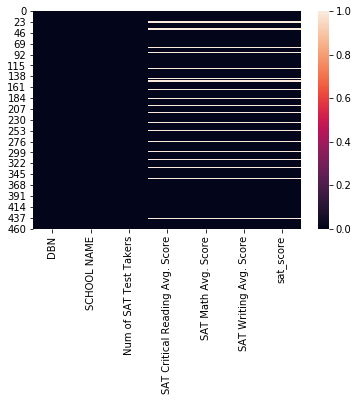

In [14]:
import seaborn as sns
%matplotlib inline
sns.heatmap(data["sat_results"].isnull())

Next, we'll want to parse the latitude and longitude coordinates for each school. This will enable us to map the schools and uncover any geographic patterns in the data. The coordinates are currently in the text field Location 1 in the hs_directory data set.

In [15]:
import re
def get_latitude (data):
    latlong = re.findall("(?<=\().+(?=\))",data)
    return (str(latlong[0]).split(", ")[0])
    
data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(get_latitude)

data["hs_directory"]["lat"].head()

0     40.67029890700047
1      40.8276026690005
2    40.842414068000494
3     40.71067947100045
4    40.718810094000446
Name: lat, dtype: object

In [16]:
def get_longitude (data):
    latlong = re.findall("(?<=\().+(?=\))",data)
    return (str(latlong[0]).split(", ")[1])
    
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(get_longitude)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

data["hs_directory"][["DBN","lat","lon"]].head()

,DBN,lat,lon
0,17K548,40.670299,-73.961648
1,09X543,40.827603,-73.904475
2,09X327,40.842414,-73.916162
3,02M280,40.710679,-74.000807
4,28Q680,40.718810,-73.806500


In our dataset, class_size, graduation, and demographics have duplicate DBN values. For example there are over 26,000 rows with at least one duplicate in DBN for class_size:

In [17]:
data["class_size"]["DBN"].duplicated().value_counts()

True     26124
False     1487
Name: DBN, dtype: int64

In [18]:
data["class_size"][data["class_size"]["DBN"].duplicated()].head(10)

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN,01,01M015
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN,01,01M015
5,1,M,M015,P.S. 015 Roberto Clemente,02,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
6,1,M,M015,P.S. 015 Roberto Clemente,03,GEN ED,-,-,-,12.0,1.0,12.0,12.0,12.0,ATS,NaN,01,01M015
7,1,M,M015,P.S. 015 Roberto Clemente,03,CTT,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN,01,01M015
8,1,M,M015,P.S. 015 Roberto Clemente,04,GEN ED,-,-,-,26.0,2.0,13.0,12.0,14.0,ATS,NaN,01,01M015
9,1,M,M015,P.S. 015 Roberto Clemente,05,GEN ED,-,-,-,27.0,1.0,27.0,27.0,27.0,ATS,NaN,01,01M015
10,1,M,M015,P.S. 015 Roberto Clemente,0K-09,SPEC ED,-,-,12:1:1,9.0,1.0,9.0,9.0,9.0,ATS,NaN,01,01M015


Seems like the data is based on the "GRADE " column. Let's explore the values that this column has, as we are only interested in high schools.

In [19]:
data["class_size"]["GRADE "].value_counts()

09-12      10644
MS Core     4762
0K-09       1384
0K          1237
01          1185
02          1167
03          1143
04          1140
05          1086
06           846
07           778
08           735
09            20
Name: GRADE , dtype: int64

Because we're dealing with high schools, we're only concerned with grades 9 through 12. That means we only want to pick rows where the value in the GRADE column is 09-12.

If we look at the values for PROGRAM TYPE, we get the following:

In [20]:
data["class_size"]["PROGRAM TYPE"].value_counts(normalize=True)

GEN ED     0.556704
CTT        0.285528
SPEC ED    0.139817
G&T        0.017951
Name: PROGRAM TYPE, dtype: float64

Each school can have multiple program types. Because GEN ED is the largest category by far (>55%), let's only select rows where PROGRAM TYPE is GEN ED.

In [21]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]
class_size.head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
225,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 9,-,63.0,3.0,21.0,19.0,25.0,STARS,NaN,01,01M292
226,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 10,-,79.0,3.0,26.3,24.0,31.0,STARS,NaN,01,01M292
227,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 11,-,38.0,2.0,19.0,16.0,22.0,STARS,NaN,01,01M292
228,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 12,-,69.0,3.0,23.0,13.0,30.0,STARS,NaN,01,01M292
229,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,MATH,Integrated Algebra,-,53.0,3.0,17.7,16.0,21.0,STARS,NaN,01,01M292


As can be seen above, DBN still isn't completely unique. This is due to the CORE COURSE (MS CORE and 9-12 ONLY) and CORE SUBJECT (MS CORE and 9-12 ONLY) columns containing various values. Clearly the data consists of subject level details that we should not just drop.

In [22]:
class_size["CORE SUBJECT (MS CORE and 9-12 ONLY)"].unique()

array(['ENGLISH', 'MATH', 'SCIENCE', 'SOCIAL STUDIES'], dtype=object)

We can take the average across all of the classes a school offers. This will give us unique DBN values, while also incorporating as much data as possible into the average. Let's find the average values for each column associated with each DBN in class_size and then reset the index and save the data back to our dictionary.

In [23]:
class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size
data["class_size"].head(10)

,DBN,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO
0,01M292,1,88.000000,4.000000,22.564286,18.500000,26.571429,NaN
1,01M332,1,46.000000,2.000000,22.000000,21.000000,23.500000,NaN
2,01M378,1,33.000000,1.000000,33.000000,33.000000,33.000000,NaN
3,01M448,1,105.687500,4.750000,22.231250,18.250000,27.062500,NaN
4,01M450,1,57.600000,2.733333,21.200000,19.400000,22.866667,NaN
5,01M458,1,28.600000,1.200000,23.000000,22.600000,23.400000,NaN
6,01M509,1,69.642857,3.000000,23.571429,20.000000,27.357143,NaN
7,01M515,1,131.117647,5.529412,22.876471,15.764706,28.588235,NaN
8,01M539,1,156.368421,6.157895,25.510526,19.473684,31.210526,NaN
9,01M650,1,64.125000,2.937500,21.781250,18.687500,24.750000,NaN


Now let's condense demographics. The first few rows look like this:

In [24]:
data["demographics"].head()

,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
0,01M015,P.S. 015 ROBERTO CLEMENTE,20052006,89.4,NaN,281,15,36,40,33,...,74,26.3,189,67.3,5,1.8,158.0,56.2,123.0,43.8
1,01M015,P.S. 015 ROBERTO CLEMENTE,20062007,89.4,NaN,243,15,29,39,38,...,68,28.0,153,63.0,4,1.6,140.0,57.6,103.0,42.4
2,01M015,P.S. 015 ROBERTO CLEMENTE,20072008,89.4,NaN,261,18,43,39,36,...,77,29.5,157,60.2,7,2.7,143.0,54.8,118.0,45.2
3,01M015,P.S. 015 ROBERTO CLEMENTE,20082009,89.4,NaN,252,17,37,44,32,...,75,29.8,149,59.1,7,2.8,149.0,59.1,103.0,40.9
4,01M015,P.S. 015 ROBERTO CLEMENTE,20092010,,96.5,208,16,40,28,32,...,67,32.2,118,56.7,6,2.9,124.0,59.6,84.0,40.4


In [25]:
data["demographics"]["schoolyear"].unique()

array([20052006, 20062007, 20072008, 20082009, 20092010, 20102011,
       20112012])

Based on the unique schoolyear values above, we can just drop any year that is older than 20112012 since that is the latest year in this dataset.

In [26]:
bool_20112012 = data["demographics"]["schoolyear"]==20112012
data["demographics"] = data["demographics"][bool_20112012]
data["demographics"].head(10)

,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
6,01M015,P.S. 015 ROBERTO CLEMENTE,20112012,NaN,89.4,189,13,31,35,28,...,63,33.3,109,57.7,4,2.1,97.0,51.3,92.0,48.7
13,01M019,P.S. 019 ASHER LEVY,20112012,NaN,61.5,328,32,46,52,54,...,81,24.7,158,48.2,28,8.5,147.0,44.8,181.0,55.2
20,01M020,PS 020 ANNA SILVER,20112012,NaN,92.5,626,52,102,121,87,...,55,8.8,357,57.0,16,2.6,330.0,52.7,296.0,47.3
27,01M034,PS 034 FRANKLIN D ROOSEVELT,20112012,NaN,99.7,401,14,34,38,36,...,90,22.4,275,68.6,8,2.0,204.0,50.9,197.0,49.1
35,01M063,PS 063 WILLIAM MCKINLEY,20112012,NaN,78.9,176,18,20,30,21,...,41,23.3,110,62.5,15,8.5,97.0,55.1,79.0,44.9
42,01M064,PS 064 ROBERT SIMON,20112012,NaN,76.9,324,27,54,50,42,...,76,23.5,193,59.6,24,7.4,184.0,56.8,140.0,43.2
49,01M110,PS 110 FLORENCE NIGHTINGALE,20112012,NaN,52.5,440,34,67,75,65,...,58,13.2,194,44.1,124,28.2,219.0,49.8,221.0,50.2
56,01M134,PS 134 HENRIETTA SZOLD,20112012,NaN,84.1,369,36,67,57,55,...,74,20.1,181,49.1,8,2.2,177.0,48.0,192.0,52.0
63,01M137,PS 137 JOHN L BERNSTEIN,20112012,NaN,82.2,230,18,43,43,39,...,57,24.8,123,53.5,7,3.0,111.0,48.3,119.0,51.7
70,01M140,PS 140 NATHAN STRAUS,20112012,NaN,82.1,407,16,37,35,39,...,66,16.2,317,77.9,7,1.7,216.0,53.1,191.0,46.9


Lastly, we'll need to condense the graduation data set. Here are the first few rows:

In [27]:
data["graduation"].head()

,Demographic,DBN,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
0,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2003,5,s,s,s,s,s,...,s,s,s,s,s,s,s,s,s,s
1,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2004,55,37,67.3%,17,30.9%,45.9%,...,17,30.9%,45.9%,20,36.4%,54.1%,15,27.3%,3,5.5%
2,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2005,64,43,67.2%,27,42.2%,62.8%,...,27,42.2%,62.8%,16,25%,37.200000000000003%,9,14.1%,9,14.1%
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43,55.1%,36,46.2%,83.7%,...,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%
4,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006 Aug,78,44,56.4%,37,47.4%,84.1%,...,37,47.4%,84.1%,7,9%,15.9%,15,19.2%,11,14.1%


There are multiple values in "Cohort" and "Demographic" for unique DBN values. If we can address that then we can condesnse this data set into rows that are unique 

In [28]:
data["graduation"]["Cohort"].unique()

array(['2003', '2004', '2005', '2006', '2006 Aug', '2001', '2002'],
      dtype=object)

In [29]:
data["graduation"]["Demographic"].unique()

array(['Total Cohort', 'Male', 'English Language Learners',
       'English Proficient Students', 'Special Education Students',
       'General Education Students', 'Asian', 'Black', 'Hispanic',
       'White', 'Female'], dtype=object)

Let's filter the data set by picking "Total Cohort" for the Demographic, and 2006 for the Cohort.

In [30]:
df = data["graduation"] 
df = df[df["Cohort"]=="2006"]
df = df[df["Demographic"]=="Total Cohort"]
data["graduation"] = df
data["graduation"].head()

,Demographic,DBN,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43,55.1%,36,46.2%,83.7%,...,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%
10,Total Cohort,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,2006,124,53,42.7%,42,33.9%,79.2%,...,34,27.4%,64.2%,11,8.9%,20.8%,46,37.1%,20,16.100000000000001%
17,Total Cohort,01M450,EAST SIDE COMMUNITY SCHOOL,2006,90,70,77.8%,67,74.400000000000006%,95.7%,...,67,74.400000000000006%,95.7%,3,3.3%,4.3%,15,16.7%,5,5.6%
24,Total Cohort,01M509,MARTA VALLE HIGH SCHOOL,2006,84,47,56%,40,47.6%,85.1%,...,23,27.4%,48.9%,7,8.300000000000001%,14.9%,25,29.8%,5,6%
31,Total Cohort,01M515,LOWER EAST SIDE PREPARATORY HIGH SCHO,2006,193,105,54.4%,91,47.2%,86.7%,...,22,11.4%,21%,14,7.3%,13.3%,53,27.5%,35,18.100000000000001%


In [31]:
data["graduation"].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 405 entries, 3 to 2494
Data columns (total 23 columns):
Demographic                           405 non-null object
DBN                                   405 non-null object
School Name                           405 non-null object
Cohort                                405 non-null object
Total Cohort                          405 non-null int64
Total Grads - n                       405 non-null object
Total Grads - % of cohort             405 non-null object
Total Regents - n                     405 non-null object
Total Regents - % of cohort           405 non-null object
Total Regents - % of grads            405 non-null object
Advanced Regents - n                  405 non-null object
Advanced Regents - % of cohort        405 non-null object
Advanced Regents - % of grads         405 non-null object
Regents w/o Advanced - n              405 non-null object
Regents w/o Advanced - % of cohort    405 non-null object
Regents w/o Advanced - % 

Before combining datasets, let's convert the Advanced Placement (AP) test scores in the ap_2010 data set from strings to numeric values. There are three columns we'll need to convert:

- AP Test Takers 
- Total Exams Taken
- Number of Exams with scores 3 4 or 5

In [32]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

print(data["ap_2010"].dtypes)

DBN                                      object
SchoolName                               object
AP Test Takers                          float64
Total Exams Taken                       float64
Number of Exams with scores 3 4 or 5    float64
dtype: object


Some of the data sets have a lot of missing DBN values, as can be seen in the plot below. We need to consider this while merging the data sets. The missing DBN values makes a left join more appropriate, as we don't want to lose too many rows when we merge. If we did an inner join, we would lose the data for many high schools.

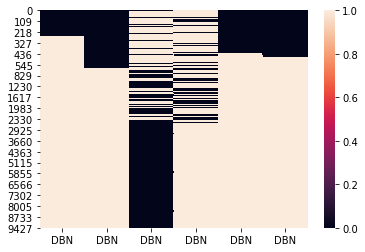

In [33]:
df_plot = pd.DataFrame()

# for key in data:
#     df_plot = pd.concat([df_plot, data[key]["DBN"]], axis=1)

df_plot = pd.concat([df_plot, data["ap_2010"]["DBN"]], axis=1)
df_plot = pd.concat([df_plot, data["class_size"]["DBN"]], axis=1)
df_plot = pd.concat([df_plot, data["demographics"]["DBN"]], axis=1)
df_plot = pd.concat([df_plot, data["graduation"]["DBN"]], axis=1)
df_plot = pd.concat([df_plot, data["hs_directory"]["DBN"]], axis=1)
df_plot = pd.concat([df_plot, data["sat_results"]["DBN"]], axis=1)

sns.heatmap(df_plot.isnull())

Both the ap_2010 and the graduation data sets have many missing DBN values, so we'll use a left join when we merge the sat_results data set with them. Because we're using a left join, our final dataframe will have all of the same DBN values as the original sat_results dataframe. First, we'll assign data["sat_results"] to the variable combined. Then, we'll merge all of the other dataframes with combined. When we're finished, combined will have all of the columns from all of the data sets.

In [34]:
combined = data["sat_results"]
combined = combined.merge(data["ap_2010"], how="left", on="DBN")
combined = combined.merge(data["graduation"], how="left", on="DBN")

combined.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,NaN,NaN,NaN,...,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.0,49.0,...,34,27.4%,64.2%,11,8.9%,20.8%,46,37.1%,20,16.100000000000001%
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.0,21.0,...,67,74.400000000000006%,95.7%,3,3.3%,4.3%,15,16.7%,5,5.6%
3,01M458,FORSYTH SATELLITE ACADEMY,7,414.0,401.0,359.0,1174.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,NaN,NaN,NaN,...,23,27.4%,48.9%,7,8.300000000000001%,14.9%,25,29.8%,5,6%


In [35]:
print(combined.shape)

(479, 33)


Now we can merge class_size, demographics, survey, and hs_directory into combined. As these files contain information that's more valuable to our analysis and also have fewer missing DBN values, we'll use the inner join type.

In [36]:
combined = combined.merge(data["class_size"], on="DBN", how="inner")
combined = combined.merge(data["demographics"], on="DBN", how="inner")
combined = combined.merge(data["survey"], on="DBN", how="inner")
combined = combined.merge(data["hs_directory"], on="DBN", how="inner")

combined.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,NaN,NaN,NaN,...,Then to Manhattan students or residents,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.0,49.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.0,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"145 Stanton Street\nNew York, NY 10002\n(40.72...",40.720569,-73.985673
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.0,574.0,525.0,1621.0,"NEW EXPLORATIONS SCI,TECH,MATH",255.0,377.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"111 Columbia Street\nNew York, NY 10002\n(40.7...",40.718725,-73.979426


In [37]:
combined.shape

(363, 159)

Compute and fill in the missing values in any columns with the overall mean for the column.

In [38]:
means = combined.mean()
combined = combined.fillna(means)
combined = combined.fillna(0)
combined.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,129.028846,197.038462,...,Then to Manhattan students or residents,Then to New York City residents,0,0,0,0,0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000000,...,0,0,0,0,0,0,0,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.000000,21.000000,...,0,0,0,0,0,0,0,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,0,129.028846,197.038462,...,0,0,0,0,0,0,0,"145 Stanton Street\nNew York, NY 10002\n(40.72...",40.720569,-73.985673
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.0,574.0,525.0,1621.0,"NEW EXPLORATIONS SCI,TECH,MATH",255.000000,377.000000,...,0,0,0,0,0,0,0,"111 Columbia Street\nNew York, NY 10002\n(40.7...",40.718725,-73.979426


We've finished cleaning and combining our data. We can try to map the statistics out on a school district level. Let's extract the school district from the DBN column. It is just the first two characters of the DBN code. We can apply a function element-wise to extract the code and save it to another column in the dataframe.

In [39]:
def extract_school_district (DBN):
    return DBN[0:2]

combined["school_dist"] = combined["DBN"].apply(extract_school_district)

combined["school_dist"].head(10)

0    01
1    01
2    01
3    01
4    01
5    01
6    02
7    02
8    02
9    02
Name: school_dist, dtype: object

Let us try to find any correlations between any of the columns and sat_score. This will help us determine which columns might be interesting to plot out or investigate further. We can use the pandas.DataFrame.corr() method on the combined dataframe from above to find all possible correlations.

In [40]:
correlations = combined.corr()
# correlations = correlations["sat_score"]
pd.set_option("max_rows",70)
print(correlations["sat_score"].dropna().sort_values(ascending=False))

sat_score                               1.000000
SAT Writing Avg. Score                  0.987771
SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
white_per                               0.620718
asian_per                               0.570730
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
asian_num                               0.475445
Number of Exams with scores 3 4 or 5    0.463245
white_num                               0.449559
N_s                                     0.423463
N_p                                     0.421530
total_students                          0.407827
NUMBER OF STUDENTS / SEATS FILLED       0.394626
female_num                              0.388631
AVERAGE CLASS SIZE                      0.381014
total_enrollment                        0.367857
NUMBER OF SECTIONS                      0.362673
aca_s_11                                0.339435
saf_s_11            

The data above is very interesting. We must always remember, that correlation does not imply causation. 
- total_enrollment has a strong positive correlation with sat_score. This is surprising because we'd expect smaller schools where students receive more attention to have higher scores. However, it looks like the opposite is true - larger schools tend to do better on the SAT. Related measures like AVERAGE CLASS SIZE and Total Exams Taken display the same high positive correlation.
- sat_score is positively correlated with percentage of being white (white_per) or asian (asian_per). The higher the percent of students who are white or asian, the higher the SAT scores and vice versa.
- sat_score is negatively correlated with percentage of being black (black_per) or asian (hispanic_per).
- zip code is poorly correlated to sat_score. This is very surprising and indicates high scores can be found by test takers in all zip codes.
- ell_percent and frl_percent are highly negatively correlated with sat_score. This appears reasonable as students who are learning english or taking it as a foreign language will most likely struggle with the SAT: an exam that requires good command of English throughout the exam.
- Although female_num and male_num are positively corelated with sat_score, the data in female_per and male_per show little to no correlation. Therefore this is more indicative of the total school size being a factor as for schools with larger population, female_num and male_num will be large.

As total enrollment appears to have such a strong correlation, let's create a scatterplot of total_enrollment vs sat_score

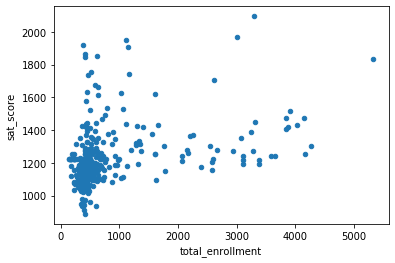

In [41]:
combined.plot.scatter(x="total_enrollment", y="sat_score")

Per the plot above, there doesn't appear to be a very strong correlation between sat_score and total_enrollment, despite the calcated pearson's coefficient of 0.37. However, there is a cluster of points at the bottom left of the plot where total_enrollment and sat_score are both low and this may be the cause of the high r value.

In [42]:
low_enrollment = combined[(combined["total_enrollment"]<1000) & (combined["sat_score"]<1000)]
pd.options.display.max_colwidth = 120
pd.set_option("max_columns",150)
# low_enrollment.head(50)
low_enrollment[["School Name", "Num of SAT Test Takers", "ell_percent", "frl_percent"]].head(50)

,School Name,Num of SAT Test Takers,ell_percent,frl_percent
91,INTERNATIONAL COMMUNITY HIGH SCHOOL,34,90.1,77.5
125,0,54,86.6,85.7
126,BRONX INTERNATIONAL HIGH SCHOOL,49,87.1,82.3
139,KINGSBRIDGE INTERNATIONAL HIGH SCHOOL,52,88.7,95.1
141,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,49,79.9,78.3
176,0,30,92.9,100.0
179,HIGH SCHOOL OF WORLD CULTURES,42,86.4,90.6
188,BROOKLYN INTERNATIONAL HIGH SCHOOL,90,83.1,80.0
225,INTERNATIONAL HIGH SCHOOL AT PROSPECT,71,91.0,80.9
237,IT TAKES A VILLAGE ACADEMY,56,30.4,76.5


Seems like a lot of the schools are for international students or students learning English. This indicates that it's actually ell_percent that correlates strongly with sat_score, rather than total_enrollment. To explore this relationship further, let's plot out ell_percent vs sat_score.

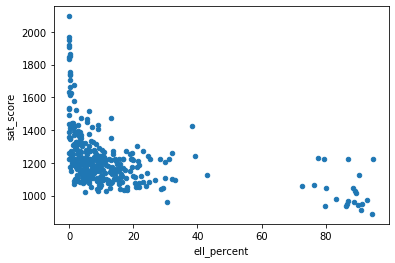

In [43]:
combined.plot.scatter(x="ell_percent", y="sat_score")

In order to explore this relationship, we'll want to map out ell_percent by school district. The map will show us which areas of the city have a lot of English language learners. We extracted the coordinates for all of the schools earlier, and stored them in the lat and lon columns. The coordinates will enable us to plot all of the schools on a map of New York City.

In [44]:
import os
import conda

conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib

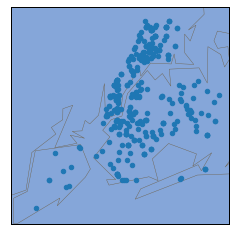

In [45]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
longitudes = combined["lon"].tolist()
latitudes = combined["lat"].tolist()

# Call the Basemap.scatter() method on m, and pass in longitudes and latitudes as arguments. 
# Pass in the keyword argument s=20 to increase the size of the points, zorder=2 to plot the points on top, latlon=True to indicate that we're passing in latitude and longitude coordinates
m.scatter(longitudes,latitudes,s=20,zorder=2,latlon=True)
plt.show()

In order to plot coordinates using Basemap above, we had to:

- Convert the pandas series containing the latitude and longitude coordinates to lists
- Make a scatterplot using the longitudes and latitudes with the scatter() method on the Basemap object.

We can see that school density is highest in Manhattan (the top of the map), and lower in Brooklyn, the Bronx, Queens, and Staten Island. Let's create a new plot but shade the plotted points using a color map that is driven by the value of ell_percent.

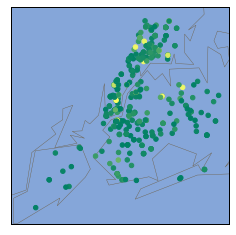

In [46]:
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
longitudes = combined["lon"].tolist()
latitudes = combined["lat"].tolist()

m.scatter(longitudes,latitudes,s=20,zorder=2,latlon=True, 
         c=combined["ell_percent"], cmap="summer")
plt.show()

To help analyze our dataset better, let us aggregate by district, which will enable us to plot ell_percent district-by-district instead of school-by-school.

In [51]:
import numpy

districts = combined.groupby("school_dist").agg(numpy.mean)
# Need to reset the index as school_dist is not a column anymore
districts.reset_index(inplace=True)
districts.head(10)

,school_dist,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO,schoolyear,fl_percent,frl_percent,total_enrollment,ell_num,ell_percent,sped_num,sped_percent,asian_num,asian_per,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,aca_p_11,saf_t_11,com_t_11,eng_t_11,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
0,01,441.833333,473.333333,439.333333,1354.500000,116.681090,173.019231,135.800000,93.500000,1.0,115.244241,5.148538,22.675415,18.798392,26.553044,0.0,20112012.0,0.0,58.983333,668.500000,42.166667,10.000000,82.000000,17.083333,134.500000,17.516667,125.500000,22.333333,214.833333,40.733333,186.000000,18.450000,328.166667,50.050000,340.333333,49.950000,76.500000,85.333333,33.166667,525.368056,38.500000,239.166667,8.233333,7.800000,7.683333,8.016667,7.066667,6.233333,6.700000,7.500000,6.768611,6.165787,6.736713,7.446898,7.433333,6.816667,7.116667,7.683333,12.0,12.0,10003.166667,659.500000,1.333333,0.0,0.0,0.0,40.719022,-73.982377
1,02,426.619092,444.186256,424.832836,1295.638184,128.908454,201.516827,157.495833,158.647849,2.0,149.818949,5.686360,25.038118,20.662667,28.593861,0.0,20112012.0,0.0,63.164583,605.604167,51.625000,13.006250,70.770833,13.212500,118.395833,14.479167,141.145833,24.733333,271.458333,49.554167,68.541667,10.056250,266.500000,44.718750,339.104167,55.281250,83.312500,86.416667,38.333333,495.171007,31.687500,190.000000,8.254167,7.495833,7.379167,7.704167,7.404167,6.520833,7.120833,7.564583,6.910660,6.204057,6.650422,7.385029,7.520833,6.720833,7.037500,7.541667,12.0,12.0,10023.770833,621.395833,1.416667,0.0,0.0,0.0,40.739699,-73.991386
2,03,428.529851,437.997512,426.915672,1293.443035,156.183494,244.522436,193.087500,183.384409,3.0,156.005994,5.839200,23.716311,19.737593,27.122831,0.0,20112012.0,0.0,58.050000,661.416667,36.916667,9.025000,63.583333,14.500000,68.000000,6.408333,181.833333,34.000000,228.250000,44.533333,172.000000,13.725000,272.166667,47.950000,389.250000,52.050000,83.166667,80.833333,36.166667,519.250000,28.166667,206.416667,8.316667,7.541667,7.508333,7.758333,6.675000,5.991667,6.533333,6.991667,6.716667,6.258333,6.633333,7.375000,7.233333,6.616667,6.891667,7.391667,12.0,12.0,10023.750000,717.916667,2.000000,0.0,0.0,0.0,40.781574,-73.977370
3,04,402.142857,416.285714,405.714286,1224.142857,129.016484,183.879121,151.035714,113.857143,4.0,132.362265,5.192610,24.101048,19.740816,27.460291,0.0,20112012.0,0.0,71.000000,569.285714,21.571429,4.557143,58.571429,13.214286,61.142857,6.128571,151.714286,30.028571,341.571429,61.400000,9.285714,1.314286,193.285714,30.514286,376.000000,69.485714,87.571429,92.714286,41.285714,504.857143,32.428571,193.142857,8.385714,7.657143,7.500000,7.928571,7.871429,7.042857,7.428571,7.885714,6.885714,6.114286,6.685714,7.571429,7.714286,6.942857,7.185714,7.785714,12.0,12.0,10029.857143,580.857143,1.142857,0.0,0.0,0.0,40.793449,-73.943215
4,05,427.159915,438.236674,419.666098,1285.062687,85.722527,115.725275,142.464286,143.677419,5.0,120.623901,4.845101,24.290247,20.447527,27.746703,0.0,20112012.0,0.0,58.671429,605.857143,21.571429,4.157143,59.714286,10.428571,32.714286,7.300000,342.571429,49.000000,195.571429,36.214286,31.285714,6.714286,300.000000,48.471429,305.857143,51.528571,82.857143,79.285714,40.428571,442.428571,27.714286,184.857143,8.085714,7.342857,7.357143,7.685714,6.857143,5.885714,6.242857,6.957143,6.314286,6.000000,6.428571,7.285714,7.085714,6.414286,6.671429,7.314286,12.0,12.0,10030.142857,609.857143,1.142857,0.0,0.0,0.0,40.817077,-73.9492

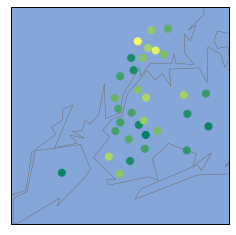

In [52]:
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()

m.scatter(longitudes,latitudes,s=50,zorder=2,latlon=True, 
         c=districts["ell_percent"], cmap="summer")
plt.show()

There are several fields in combined that originally came from a survey of parents, teachers, and students. We can generate a bar plot of the correlations between these fields and sat_score. We previously computed the correlations and we can just plot that dataframe to see the data.

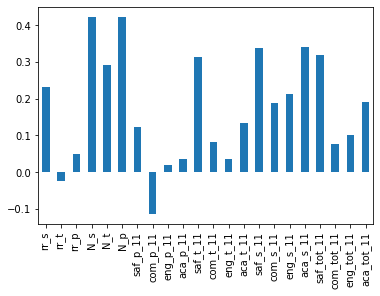

In [47]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
columns.remove("DBN")
correlations["sat_score"][columns].plot.bar()

There are high correlations between N_s, N_t, N_p and sat_score. Since these columns are correlated with total_enrollment, it makes sense that they would be high.

It is also interesting that rr_s, the student response rate, or the percentage of students that completed the survey, correlates with sat_score. Perhaps students who are more likely to fill out surveys may be more likely to also be doing well on the SAT. Or, stated differently, if one is doing well at school, and therefore is more likely to perform well on the SAT, then he/she is also more likely to respond to the survey.

How students and teachers percieved safety (saf_t_11 and saf_s_11) correlate with sat_score. Perhpas it is hard to teach or learn in an unsafe environment.

The last interesting correlation is the aca_s_11, which indicates how the student perceives academic standards, correlates with sat_score, but this is not true for aca_t_11, how teachers perceive academic standards, or aca_p_11, how parents perceive academic standards.

From the bar graph above, saf_t_11 and saf_s_11, which measure how teachers and students perceive safety at school, correlated highly with sat_score. We can look into this relationship a bit more, and try to figure out which schools have low safety scores.

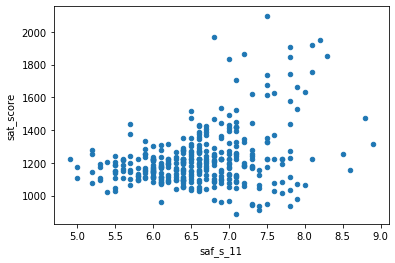

In [48]:
# Make a scatter plot of the saf_s_11 column vs. the sat_score in combined
combined[["sat_score", "saf_s_11"]].plot.scatter(y="sat_score",x="saf_s_11")

There appears to be some amount of correlation between safety and SAT scores, although nothing consistent or strong.  It looks like there are a few schools with extremely high SAT scores and high safety scores. There are a few schools with low safety scores and low SAT scores. No school with a safety score lower than 6 has an average SAT score higher than about 1500. Let's map out safety scores by district to get another representation of the data.

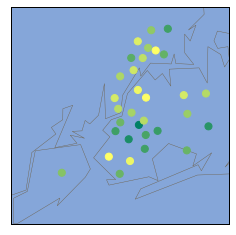

In [53]:
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()
# Compute the average safety score for each district.
m.scatter(longitudes,latitudes,s=50,zorder=2,latlon=True, 
         c=districts["saf_s_11"], cmap="summer")
plt.show()

Upper Manhattan and parts of Queens and the Bronx tend to have higher safety scores, whereas Brooklyn has low safety scores.

# Investigate racial differences in SAT scores

There are a few columns that indicate the percentage of each race at a given school. By plotting out the correlations between these columns and sat_score, we can determine whether there are any racial differences in SAT performance.

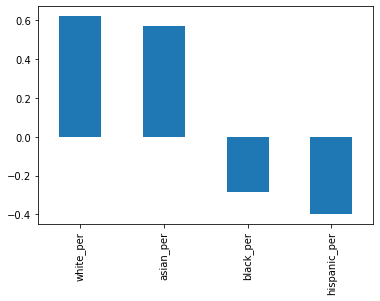

In [55]:
race_per = ["white_per", "asian_per", "black_per", "hispanic_per"]
correlations["sat_score"][race_per].plot(kind="bar")

It looks like a higher percentage of white or asian students at a school correlates positively with sat score, whereas a higher percentage of black or hispanic students correlates negatively with sat score. Let's explore schools with low SAT scores and high values for hispanic_per

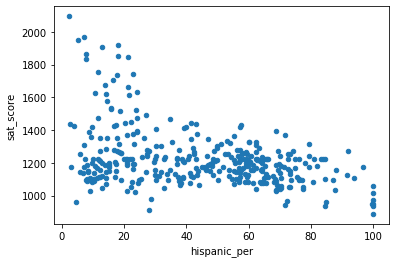

In [56]:
combined.plot.scatter(y="sat_score",x="hispanic_per")

The plot shows the possible negative correlation between the percent of hispanic students in the school and SAT scores. There are some schools with a very high percent of hispanic students, and these all have very low SAT scores. Let us drill down into schools with a hispanic_per greater than 95%

In [60]:
combined[combined["hispanic_per"]>95][["SCHOOL NAME","Num of SAT Test Takers","Location 1","school_dist"]]

,SCHOOL NAME,Num of SAT Test Takers,Location 1,school_dist
44,MANHATTAN BRIDGES HIGH SCHOOL,66,"525 West 50Th Street\nNew York, NY 10019\n(40.76502670800045, -73.99251657799965)",02
82,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,70,"511 West 182Nd Street\nNew York, NY 10033\n(40.84887878800049, -73.93080651699967)",06
89,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND MATHEMATICS,56,"501 West 165Th\nNew York, NY 10032\n(40.83803232200046, -73.93837101799966)",06
125,ACADEMY FOR LANGUAGE AND TECHNOLOGY,54,"1700 Macombs Road\nBronx, NY 10453\n(40.84910216800046, -73.91608844099966)",09
141,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,49,"2780 Reservoir Avenue\nBronx, NY 10468\n(40.87037746700048, -73.89816295199967)",10
176,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,30,"1300 Boynton Avenue\nBronx, NY 10472\n(40.83136649000045, -73.87882327699964)",12
253,MULTICULTURAL HIGH SCHOOL,29,"999 Jamaica Avenue\nBrooklyn, NY 11208\n(40.69114396200047, -73.86842605699962)",19
286,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,55,"45-10 94Th Street\nElmhurst, NY 11373\n(40.74330287300046, -73.87057497699965)",24


Most of these schools are international schools and they have a lower number of SAT test takers. That means that these students have probably not been taught a curriculum that is geared towards the SAT and if English is not their first language then they would have a harder time at getting high SAT scores. In fact, the lower number of SAT test takers probably skews the correlation more than actually is the case due to the low number of test takers.

In [62]:
combined[(combined["hispanic_per"]<10) & (
            combined["sat_score"]>1800)][["SCHOOL NAME","Num of SAT Test Takers","Location 1","school_dist", "hispanic_per", "white_per", "asian_per", "black_per"]]


,SCHOOL NAME,Num of SAT Test Takers,Location 1,school_dist,hispanic_per,white_per,asian_per,black_per
37,STUYVESANT HIGH SCHOOL,832,"345 Chambers Street\nNew York, NY 10282\n(40.71774641500048, -74.01404904299966)",02,2.4,23.7,72.1,1.2
151,BRONX HIGH SCHOOL OF SCIENCE,731,"75 West 205 Street\nBronx, NY 10468\n(40.87705636800047, -73.88978035099967)",10,7.2,25.4,63.5,3.5
187,BROOKLYN TECHNICAL HIGH SCHOOL,1277,"29 Ft Greene Place\nBrooklyn, NY 11217\n(40.688107423000474, -73.97674507199963)",13,7.9,21.3,60.3,10.2
327,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK COLLEGE,121,"94-50 159 Street\nJamaica, NY 11433\n(40.7009987670005, -73.79815352399964)",28,7.9,6.7,74.4,10.5
356,STATEN ISLAND TECHNICAL HIGH SCHOOL,227,"485 Clawson Street\nStaten Island, NY 10306\n(40.567913003000456, -74.11536224299965)",31,5.3,61.3,31.8,1.1


These top schools appear to have competitive entrance requirements and attract a much higher percent of asian students and white students than hispanic of black. Perhaps they are better funded, and selective in their admission process. Also, there may be huge social pressure on students (especially Asian) to score well in exams.

# Investigate gender differences in SAT scores

Let's plot the correlations between each of the columns male_per & female_per and sat_score.

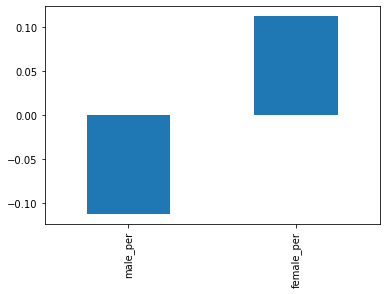

In [67]:
correlations["sat_score"][["male_per","female_per"]].plot.bar()

Neither correlation is extremely strong. The r value is around +/- 0.1. Let us look at schools with high SAT scores and a high female_per, by first looking at a scatter plot and then listing out and researching some schools.

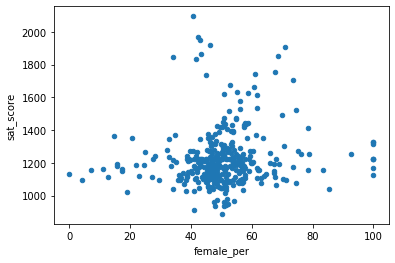

In [68]:
combined.plot.scatter(y="sat_score",x="female_per")

In [69]:
combined[(combined["female_per"]>60) & (
            combined["sat_score"]>1700)][["SCHOOL NAME","Num of SAT Test Takers","Location 1","school_dist", "male_per", "female_per"]]


,SCHOOL NAME,Num of SAT Test Takers,Location 1,school_dist,male_per,female_per
5,BARD HIGH SCHOOL EARLY COLLEGE,130,"525 East Houston Street\nNew York, NY 10002\n(40.718961617000446, -73.97606602099967)",01,31.3,68.7
26,ELEANOR ROOSEVELT HIGH SCHOOL,127,"411 East 76 Street\nNew York, NY 10021\n(40.77011647100045, -73.95337910099965)",02,32.5,67.5
60,BEACON HIGH SCHOOL,261,"227-243 West 61St Street\nNew York, NY 10023\n(40.772158119000494, -73.98779653499963)",03,39.0,61.0
61,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & ART AND PERFORMING ARTS,531,"100 Amsterdam Avenue\nNew York, NY 10023\n(40.773670507000475, -73.98526855799963)",03,26.4,73.6
302,TOWNSEND HARRIS HIGH SCHOOL,278,"149-11 Melbourne Avenue\nFlushing, NY 11367\n(40.73440841000047, -73.82141748299966)",25,28.9,71.1


These schools all seem to be highly regarded schools with an advanced curriculum and a rigorous application process. Students seeking admission would be very motivated and through self selection, appear to be well suited to get good SAT scores. That does not explain why they skew towards higher percentage of female students. There is only one such school with a high SAT average that also has a high percent of male students.

In [70]:
combined[(combined["male_per"]>60) & (
            combined["sat_score"]>1700)][["SCHOOL NAME","Num of SAT Test Takers","Location 1","school_dist", "male_per", "female_per"]]

,SCHOOL NAME,Num of SAT Test Takers,Location 1,school_dist,male_per,female_per
79,"HIGH SCHOOL FOR MATHEMATICS, SCIENCE AND ENGINEERING AT CITY COLLEGE",101,"240 Convent Ave\nNew York, NY 10031\n(40.821123112000464, -73.94884524399964)",05,65.8,34.2
